# Survival analysis of churners with the lifelines python package

Use case: Our aim is to analyze customer data and get insights on which customer groups tend to churn earlier to be able to develop focused customer retention programs.

Dataset: Telco Customer Churn Dataset from Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn/)

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
churn = pd.read_csv("../data/Kaggle-Telco-Customer-Churn.csv")

In [3]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def convert_cat_cols(colnames, df):
    for colname in colnames:
        lb = LabelEncoder()
        df[colname]=lb.fit_transform(df[colname])
        print(colname, ":", lb.classes_)
    return df

In [5]:
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce')
churn = convert_cat_cols(['Churn'], churn)

Churn : ['No' 'Yes']


## 2. Kaplan-Meier estimator

* All observations - both censored and defaulted - are used in estimation
* shows no individual estimations but the overall population survival distribution

In [6]:
from lifelines import KaplanMeierFitter

In [7]:
km = KaplanMeierFitter()

In [8]:
km.fit(churn['tenure'], churn['Churn'], label='Kaplan-Meier estimate')

<lifelines.KaplanMeierFitter:"Kaplan-Meier estimate", fitted with 7043 total observations, 5174 right-censored observations>

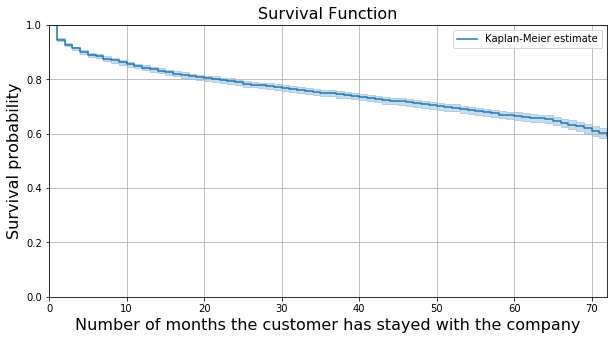

In [9]:
km.plot(figsize=(10,5))
plt.ylim((0,1))
plt.ylabel("Survival probability", fontsize=16)
plt.xlabel("Number of months the customer has stayed with the company", fontsize=16)
plt.title("Survival Function", fontsize=16)
plt.grid()

In [10]:
km.survival_function_at_times(12)

12    0.8432
Name: Kaplan-Meier estimate, dtype: float64

#### Survival Function:
* shows percentage of surviving vs time
* survival function defines the probability the death event has not occurred yet at time t
* death event = customer churn
* e.g. the probability a customer does not churn at the end of the first year (12 months) is 0.84.

## 3. Survival curves of different groups

In [11]:
def fit_km_groups(colname, df):
    km_fitters = []
    col_values = list(df[colname].unique())
    for i in range(len(col_values)):
        km_fitters.append(KaplanMeierFitter())
        df_subset = df[df[colname]==col_values[i]]
        km_fitters[i].fit(df_subset['tenure'], df_subset['Churn'], label=colname + ' = ' + str(col_values[i]))
        km_fitters[i].plot(figsize=(10,5))
    plt.ylim((0,1.1))
    plt.ylabel("Survival probability", fontsize=16)
    plt.xlabel("Number of months the customer has stayed with the company", fontsize=16)
    plt.title("Survival Function based on "+colname, fontsize=14)
    plt.grid()
    return km_fitters

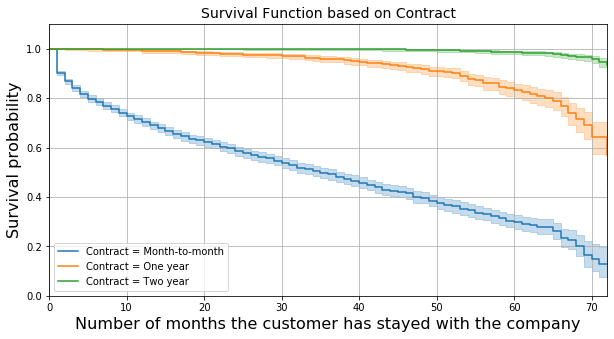

In [12]:
km_fitters = fit_km_groups('Contract', churn)

In [13]:
print(km_fitters[0].survival_function_at_times(36))
print(km_fitters[1].survival_function_at_times(36))
print(km_fitters[2].survival_function_at_times(36))

36    0.491104
Name: Contract = Month-to-month, dtype: float64
36    0.959307
Name: Contract = One year, dtype: float64
36    0.998676
Name: Contract = Two year, dtype: float64


* The probability that a customer has not churned yet after 3 years with month-to-month contract is low, 0.49. Those with two year contract tend to stay further at the company, 99 % of them does not churn even in the third year.

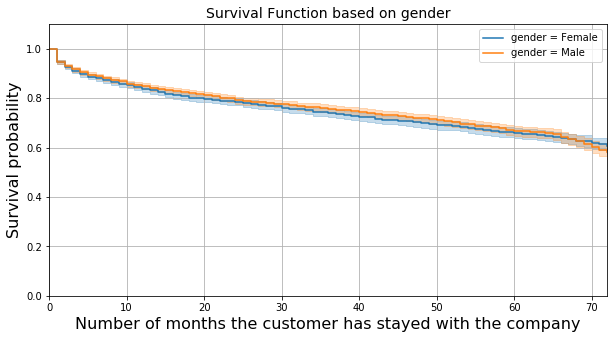

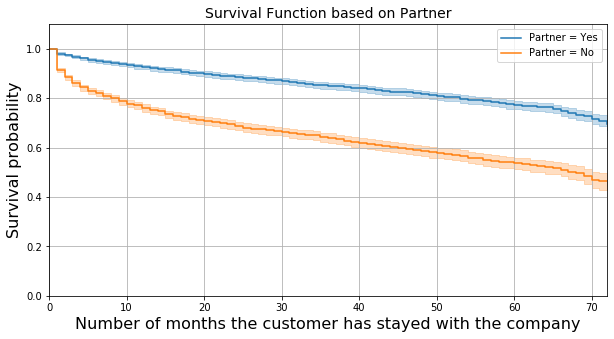

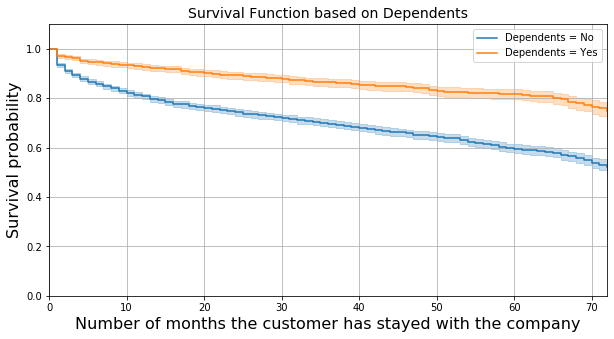

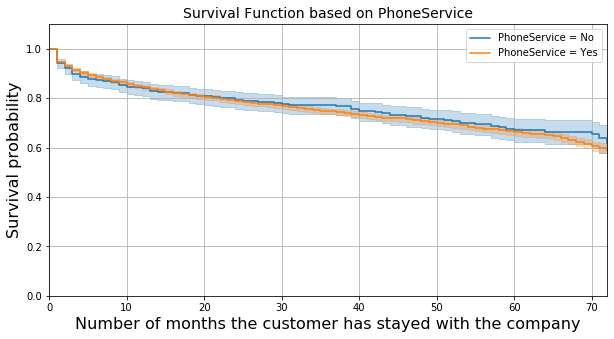

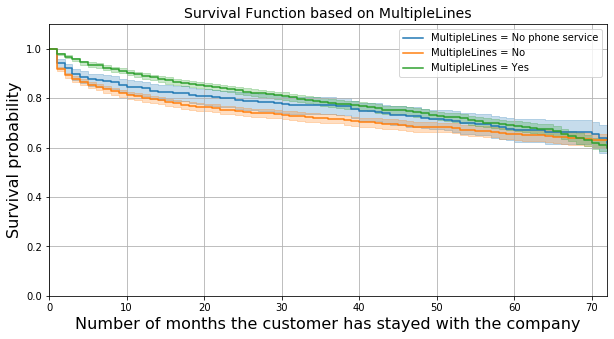

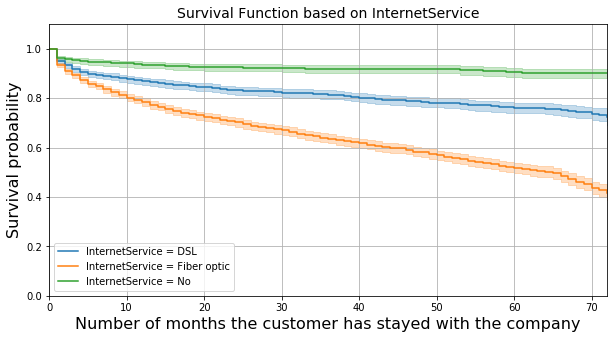

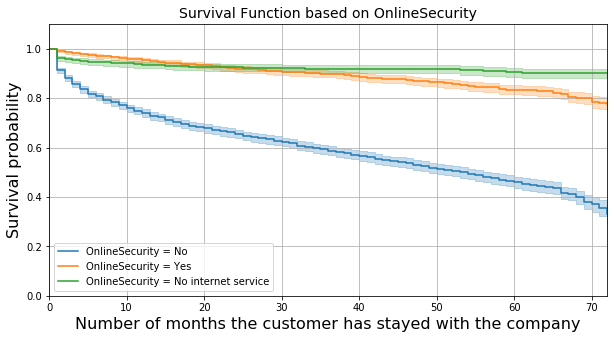

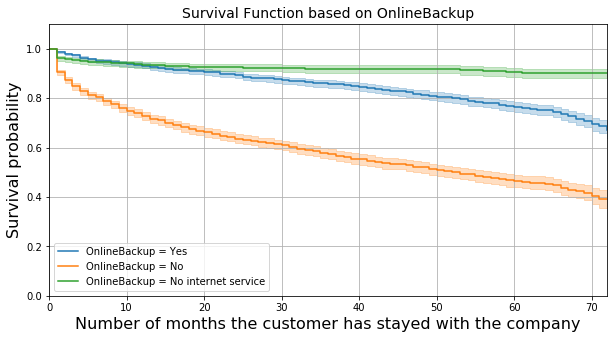

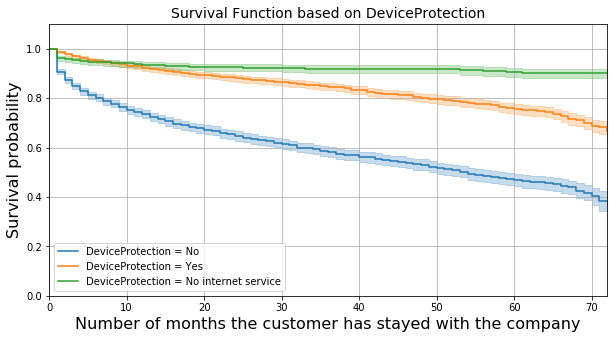

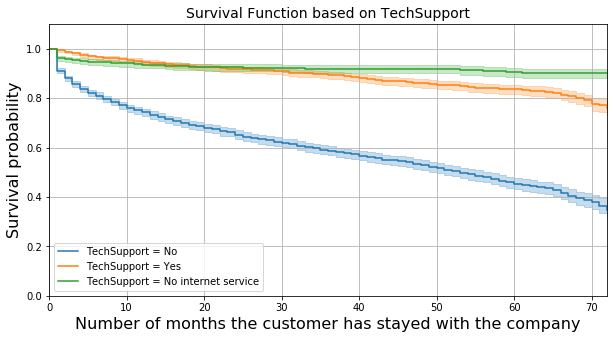

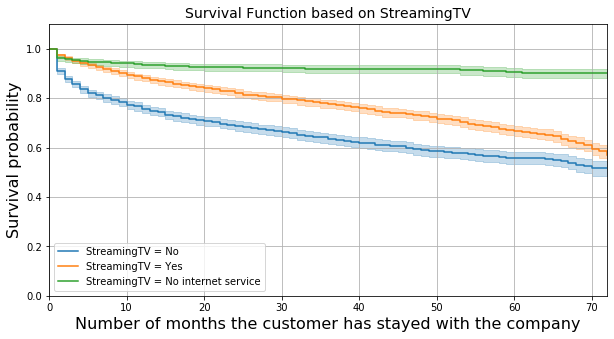

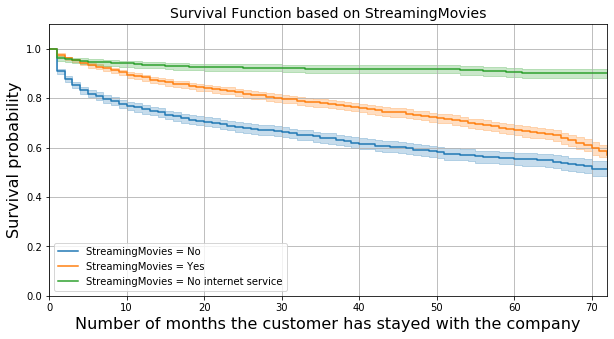

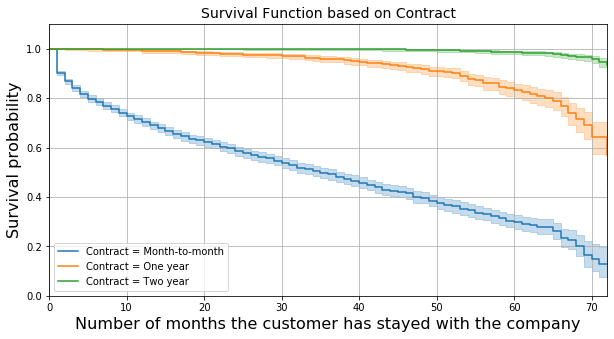

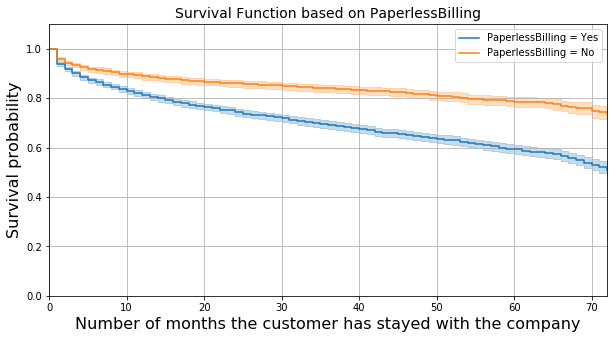

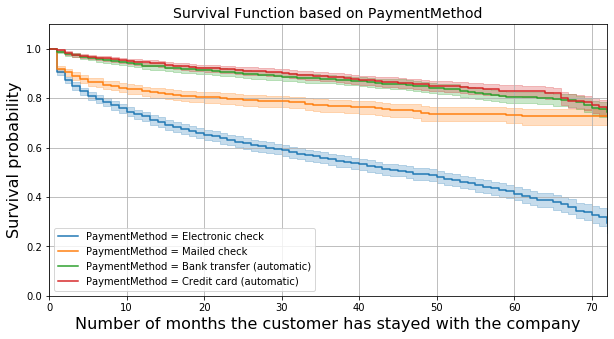

In [14]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for col in cat_cols:
    _ = fit_km_groups(col, churn)
    plt.show()

* The customer's gender and whether they have a phone service does not have imact on their survival function.
* A customer without a partner leaves the company earlier than customers with a partner. A customer who does not have dependants also tends to churn earlier.
* The customer's internet service provider has an imact on churn: at the 36th month the probability that a customer has not churned yet with a fiber optic service is only 0.63 while with no internet service this probability is 0.91.

## 4. Cox Regression

* Kaplan-Meier estimator involved only time and censorship features
* Cox Regression (1972) involves additional data as covariates  
* In a Cox proportional hazards regression model, the measure of effect is the hazard rate, which is the risk of failure (i.e., the risk or probability of suffering the event of interest), given that the participant has survived up to a specific time.

In [15]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
churn = convert_cat_cols(cat_cols, churn)
churn.fillna(0, inplace=True)

gender : ['Female' 'Male']
Partner : ['No' 'Yes']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'No phone service' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'No internet service' 'Yes']
OnlineBackup : ['No' 'No internet service' 'Yes']
DeviceProtection : ['No' 'No internet service' 'Yes']
TechSupport : ['No' 'No internet service' 'Yes']
StreamingTV : ['No' 'No internet service' 'Yes']
StreamingMovies : ['No' 'No internet service' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['No' 'Yes']
PaymentMethod : ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
Churn : [0 1]


In [16]:
from lifelines import CoxPHFitter

In [17]:
cph = CoxPHFitter()
features = list(churn.columns)[1:]
cph.fit(churn[features], duration_col='tenure', event_col='Churn')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

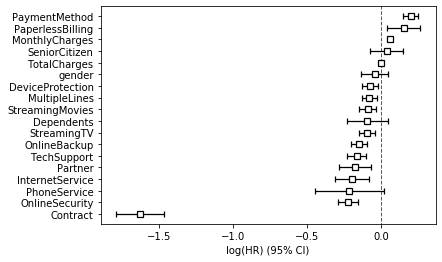

In [18]:
cph.print_summary()
cph.plot()
plt.show()

In [19]:
# predict the median lifetimes for the individuals.
cph.predict_median(churn[features])[0:10]

0    22.0
1    49.0
2    13.0
3    61.0
4     4.0
5     4.0
6    25.0
7    25.0
8    33.0
9    72.0
Name: 0.5, dtype: float64

__Baseline hazard:__
* The baseline hazard and represents the hazard when all of the predictors (or independent variables) X1, X2 , Xp are equal to zero
* The rate of suffering the event of interest in the next instant, is the product of the baseline hazard (h0(t)) and the exponential function of the linear combination of the predictors. Thus, the predictors have a multiplicative or proportional effect on the predicted hazard.

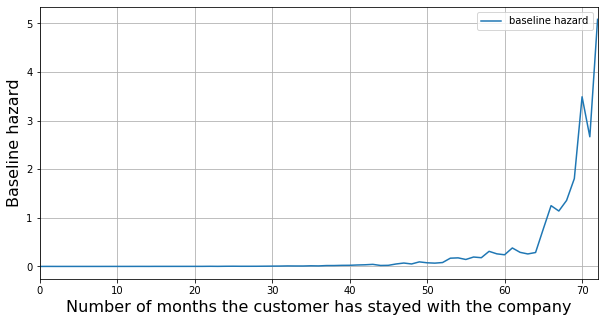

In [20]:
cph.baseline_hazard_.plot(figsize=(10,5))
plt.ylabel("Baseline hazard", fontsize=16)
plt.xlabel("Number of months the customer has stayed with the company", fontsize=16)
plt.grid()

In [21]:
cph.hazard_ratios_

gender              0.958543
SeniorCitizen       1.039397
Partner             0.839104
Dependents          0.911442
PhoneService        0.807882
MultipleLines       0.924262
InternetService     0.822120
OnlineSecurity      0.799797
OnlineBackup        0.862573
DeviceProtection    0.928917
TechSupport         0.849261
StreamingTV         0.911242
StreamingMovies     0.912600
Contract            0.196411
PaperlessBilling    1.166224
PaymentMethod       1.219792
MonthlyCharges      1.062756
TotalCharges        0.998411
Name: exp(coef), dtype: float64

### The impact of a covariate
* vary a single covariate while holding everything else equal
* useful to understand the impact of a covariate, given the model

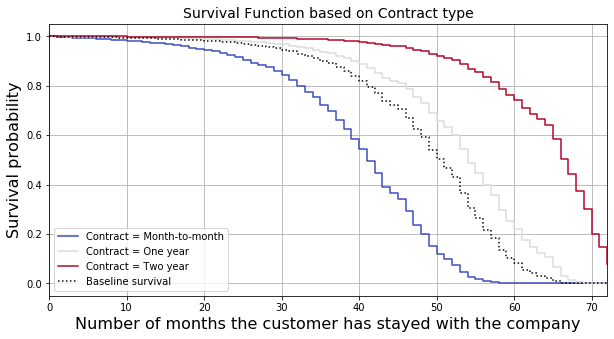

In [22]:
cph.plot_covariate_groups(covariates='Contract', values=[0, 1, 2], cmap='coolwarm', figsize=(10,5))
plt.xlabel("Number of months the customer has stayed with the company", fontsize=16)
plt.ylabel("Survival probability", fontsize=16)
plt.legend(['Contract = Month-to-month', 'Contract = One year', 'Contract = Two year', 'Baseline survival'])
plt.title("Survival Function based on Contract type", fontsize=14)
plt.grid()

* Contract : 0='Month-to-month', 1='One year', 2='Two year'. Those with two year contract tend to stay further at the company.

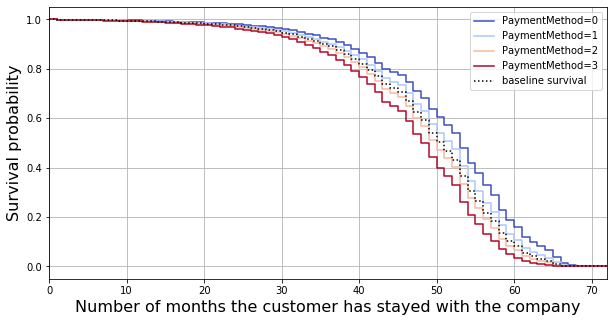

In [23]:
cph.plot_covariate_groups(covariates='PaymentMethod', values=[0, 1, 2, 3], cmap='coolwarm', figsize=(10,5))
plt.xlabel("Number of months the customer has stayed with the company", fontsize=16)
plt.ylabel("Survival probability", fontsize=16)
plt.grid()

* PaymentMethod : 0=Bank transfer (automatic), 1=Credit card (automatic), 2=Electronic check, 3=Mailed check
* The customers with automatic payment methods, like bank transfer and credit card tend to churn later than those using electronic or mailed checks.

### Survival curves of individual customers

In [24]:
churn_orig = pd.read_csv("../data/Kaggle-Telco-Customer-Churn.csv")
churn_orig.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


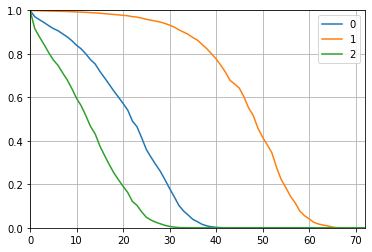

In [25]:
cph.predict_survival_function(churn[features][0:3]).plot()
plt.ylim((0,1))
plt.grid()

References:
* Anurag Pandey (2019). Survival Analysis: Intuition & Implementation in Python. Towards Data Science blog.  
https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
* CamDavidsonPilon/lifelines: v0.24.16.  
https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
* Laura Löschmann, Daria Smorodina. (2020). Deep Learning for Survival Analysis.  SEMINAR INFORMATION SYSTEMS (WS19/20).  
https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/
* Lisa Sullivan. Survival Analysis. Boston University School of Public Health. 
https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html